# Goal of the Notebook

This notebook contains all things relevant to the Content based Recommender Part of the project.

The spotify data contains for each track many features like **danceability**, **energy**, **loudness**, **speechiness**, **acousticness**, **instrumentalness**, as well as the genre of the Artist.

The goal is to create a clustering among the Tracks.

This will help for two reasons : 

- It is easy to compute the goodness of fit of a clustering
- We will be able to sample Tracks from a cluster, to make the user discover new similar songs
    - This adds stochasticity, and thus variety, the playlist will never be exactly the same
    - We should have enough clusters to guarantee that tracks in a same cluster are close enough for them to be recommended
    

In [1]:
import surprise

In [2]:
import pandas as pd
import dask.dataframe as dd
import tarfile
import scipy
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import surprise
import pickle 
import seaborn as sns

from dask.delayed import delayed

from surprise import Dataset, Reader
from surprise import SVD, SVDpp, NMF
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.prediction_algorithms.knns import KNNBaseline
from surprise.prediction_algorithms.co_clustering import CoClustering
from surprise import accuracy

from sklearn.manifold import TSNE
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

### Load Spotify Features data

In [3]:
famous_tracks_rec = pd.read_csv('data/features.csv')

#### Pre-processing of Data

For the discrete data, we mark the column as categorical, and compute a dummies df (with one-hot representation)

In [4]:
# column types
discrete_data = ['key', 'mode', 'time_signature']
continuous_data = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

# set discrete data to categorical
for c in discrete_data :
    famous_tracks_rec[c] = famous_tracks_rec[c].astype('category')

# keep only important columns
filtered_attrs = famous_tracks_rec.set_index(['musicbrainz-track-id'])[continuous_data + discrete_data]

# compute dummies df
dummies_df = pd.get_dummies(filtered_attrs)

#### Handling music genres

Since we have a lot of many different genres (936), in a set representation, we will create a one-hot representation for each genre in the sets. This assumes that there is no intermediary distance between genres (e.g. hard-rock is considered as completely different genre compared to rock), but we couldn't really obtain a better representation of closeness of sub-genres, so we had to make this assumption.

The handling of the set of genres was inspired by the article [Dealing with List Values in Pandas Dataframes by Max Hilsdorf](https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173).

In [5]:
# Get Set of genre from string
genres_tracks = famous_tracks_rec['genres']
genres_tracks = genres_tracks.apply(lambda x : list(eval(x)))

# compute all unique genres
unique_genres = set()
for g in genres_tracks:
    for i in g :
        unique_genres.add(i)
        
unique_genres

def generate_col_for_genre(tracks, unique_genres) :
    bool_dict = {}
    for i, item in enumerate(unique_genres):
        bool_dict[item] = tracks.apply(lambda x: item in x)
    return pd.DataFrame(bool_dict)

# generate track x genres matrix
genres_bool = generate_col_for_genre(genres_tracks, unique_genres)
genres_bool.astype(int).head(1)

dance rock  baltimore indie  finnish metal  trip hop  oc indie  \
0           0                0              0         0         0   

   heartland rock  norrbotten indie  new french touch  neo soul  etherpop  \
0               0                 0                 0         0         0   

   ...  electro-industrial  scottish indie  latin jazz  electra  \
0  ...                   0               0           0        0   

   swedish house  aussietronica  poezja spiewana  christian music  pixie  \
0              0              0                0                0      0   

   cyberpunk  
0          0  

[1 rows x 936 columns]

### Merging Back Genres with Musical features and Scaling

After merging together our dataframes, we have to scale features so as to give same weight to each feature.

This may mean that our genres have much more weight than other features (since we have most columns dedicates to genres) but it should actually be fine since most of these column are all empty (and thus don't imply much distance).

We also create scaled version of the features dataframe without the genres, to verify if the clustering isn't simply better without the genres.

In [6]:
from sklearn.preprocessing import MinMaxScaler

merged_df = pd.concat([dummies_df.reset_index(), genres_bool.astype(int)],axis=1,ignore_index=True).set_index(0)

scaler = MinMaxScaler()
merged_scaled = pd.DataFrame(scaler.fit_transform(merged_df))
merged_scaled.columns = merged_df.columns
merged_scaled.index   = merged_df.index

features_scaled = pd.DataFrame(scaler.fit_transform(dummies_df))
features_scaled.columns = dummies_df.columns
features_scaled.index   = dummies_df.index

#### We can show some summary metrics for each feature (only the first few are relevant) :

In [7]:
merged_scaled.describe()

1            2            3            4            5    \
count  7938.000000  7938.000000  7938.000000  7938.000000  7938.000000   
mean      0.491501     0.675303     0.747586     0.044299     0.217000   
std       0.180359     0.238625     0.101872     0.067756     0.297332   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.368296     0.511290     0.700516     0.011312     0.004135   
50%       0.495070     0.728606     0.769399     0.020814     0.051053   
75%       0.616426     0.874818     0.818858     0.046267     0.349397   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               6            7            8            9            10   ...  \
count  7938.000000  7938.000000  7938.000000  7938.000000  7938.000000  ...   
mean      0.170305     0.184857     0.465640     0.445007     0.124988  ...   
std       0.295484     0.161617     0.260606     0.157403     0.055065  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000016     0.085627     0.251260     0.333576     0.095233  ...   
50%       0.002793     0.117227     0.451815     0.440601     0.117187  ...   
75%       0.183934     0.240571     0.672940     0.538990     0.145057  ...   
max       1.000000     1.000000     1.000000     1.000000     1.000000  ...   

               955          956          957          958          959  \
count  7938.000000  7938.000000  7938.000000  7938.000000  7938.000000   
mean      0.003401     0.010456     0.000126     0.001134     0.000126   
std       0.058226     0.101725     0.011224     0.033655     0.011224   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               960          961          962          963          964  
count  7938.000000  7938.000000  7938.000000  7938.000000  7938.000000  
mean      0.000126     0.000126     0.000252     0.001890     0.012472  
std       0.011224     0.011224     0.015872     0.043432     0.110985  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 964 columns]

## Clustering : Dimensionality reduction

Since we have way too many features to perform a meaningful clustering, we first perform dimensionality reduction using TruncatedSVD. 

TruncatedSVD should be able to work with Sparse matrices efficiently, which is nice in our case.

In [8]:
from sklearn.decomposition import TruncatedSVD

X_merged   = merged_scaled.values
X_features = features_scaled.values

X_merged_red = TruncatedSVD(n_components=30).fit_transform(X_merged)
X_features_red = TruncatedSVD(n_components=10).fit_transform(X_features)

## Clustering : Selecting K

Now that we have our embedding, we can select the number of clusters.

For that, we use three measures to compute the Elbow method : 
- Distortion (sum of squares error, the usual)
- Silhouette score (Higher is better)
- Calinski harabasz score (intergroup variance / intragroup variance, higher is better)

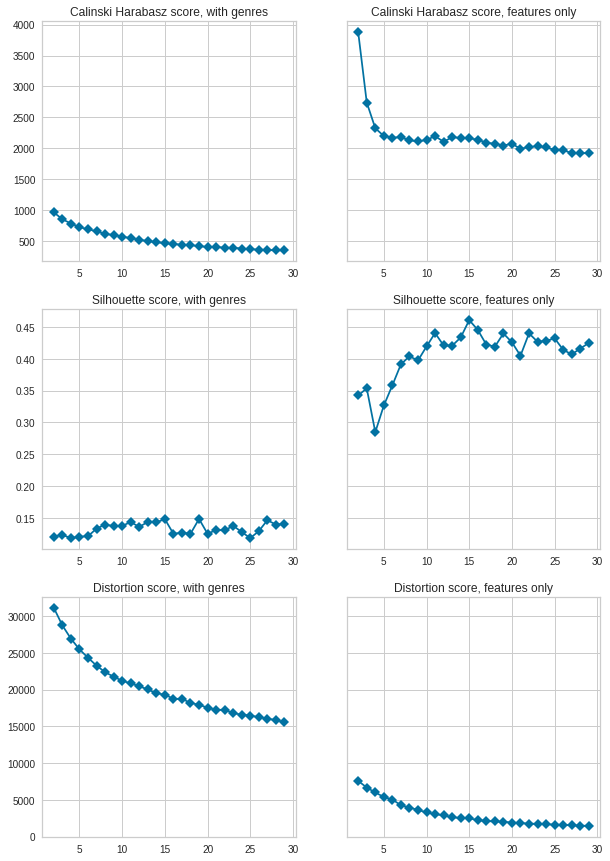

In [9]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

fig, axs = plt.subplots(nrows=3,ncols=2, figsize=(10,15), sharey='row')

# Instantiate the clustering model and visualizer
model = KMeans()

names = ['with genres', 'features only']

for i,X in enumerate([X_merged_red, X_features_red]):
    
    # visualizer with calinski scoring
    visualizer = KElbowVisualizer(
        model, k=(2,30), timings=False, metric='calinski_harabasz', ax = axs[0][i], locate_elbow=False
    )
    visualizer.fit(X)        

    # visualizer with silhouette scoring
    visualizer = KElbowVisualizer(
        model, k=(2,30), metric='silhouette', timings=False, ax=axs[1][i], locate_elbow=False
    )
    visualizer.fit(X)        

    # visualizer with distortion scoring
    visualizer = KElbowVisualizer(
        model, k=(2,30), metric='distortion', timings=False, ax=axs[2][i], locate_elbow=False
    )
    visualizer.fit(X)        

    axs[0][i].set(title=f'Calinski Harabasz score, {names[i]}')
    axs[1][i].set(title=f'Silhouette score, {names[i]}')
    axs[2][i].set(title=f'Distortion score, {names[i]}')

The 3 scoring methods don't really agree on which number of clusters is better (especially the Calinski Harabasz which would suggest that the clustering should have the lowest amount of cluster possible).

However, we can definitely say that the dataset without the genres performs unanimously better. 

This could be due to many reasons, and it is probable that by including the genres in a better way (**with less genres**), it would perform better, but for the time we have left with this project, we simply accept that using only the features performs better, and select only the dataset with features.

The comparison between the two methods makes the elbow less visible, so we plot it only for the features dataset: 

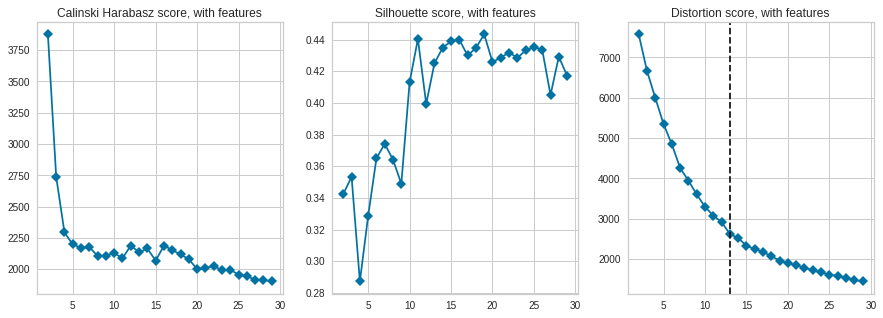

In [10]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

# Instantiate the clustering model and visualizer
model = KMeans()

names = ['with genres', 'features only']

for i,X in enumerate([X_features_red]):
    
    # visualizer with calinski scoring
    visualizer = KElbowVisualizer(
        model, k=(2,30), timings=False, metric='calinski_harabasz', ax = axs[0], locate_elbow=False
    )
    visualizer.fit(X)        

    # visualizer with silhouette scoring
    visualizer = KElbowVisualizer(
        model, k=(2,30), metric='silhouette', timings=False, ax=axs[1], locate_elbow=False
    )
    visualizer.fit(X)        

    # visualizer with distortion scoring
    visualizer = KElbowVisualizer(
        model, k=(2,30), metric='distortion', timings=False, ax=axs[2], locate_elbow=True
    )
    visualizer.fit(X)        

    axs[0].set(title=f'Calinski Harabasz score, with features')
    axs[1].set(title=f'Silhouette score, with features')
    axs[2].set(title=f'Distortion score, with features')

It looks better now !

From the Silhouette score and Distortion scores together, we think that k=16 should be a decent choice : it maximizes the silhouette score, and is still reasonably in the Elbow with respect to the Distortion score.

## Clustering : Visualizing Clustering results (metrics)

In [11]:
optimal_k = 16
model = KMeans(16, random_state=42)

### Silhouette Visualizer

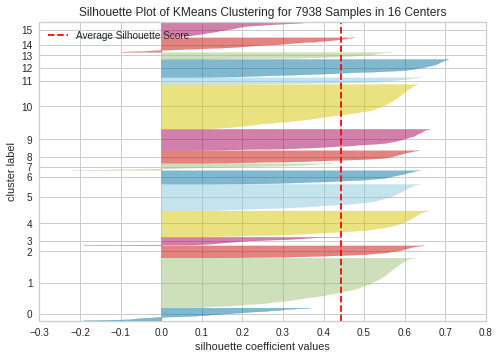

In [12]:
from yellowbrick.cluster import SilhouetteVisualizer


# Instantiate the clustering model and visualizer

visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_features_red)# Fit the data to the visualizer
visualizer.show();       # Finalize and render the figure

Our clusters seem to be reasonably well balanced. Some clusters have a silhouette score which is slightly below the average but this is to be expected.

### InterCluster distance

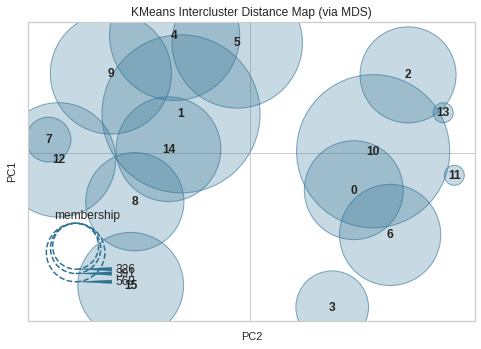

In [13]:
from yellowbrick.cluster import InterclusterDistance

# Instantiate the clustering model and visualizer
visualizer = InterclusterDistance(model)

visualizer.fit(X_features_red)        # Fit the data to the visualizer
visualizer.show();

It looks like our clusters are all fairly close to one another.

We again see that the size of the cluster seems to be reasonably balanced.

## Clustering : Visualizing Clustering results (TSNE)

We can now perform T-SNE to visualize in 2D space, the tracks and their labels.

In [14]:
import numpy as np
from sklearn.manifold import TSNE

#X = dummies_df.values
X_embedded = TSNE(n_components=2).fit_transform(X_features_red)

embed_df = pd.concat([famous_tracks_rec[['track-name', 'artist-name','genres']], pd.DataFrame(X_embedded,columns=['x','y']), pd.DataFrame(model.labels_, columns=['color'])], axis=1)

#### Plotting with plotly so we can have information about the track name, artist name, and genres on hover.

In [15]:
from ipywidgets import interact
def plot_embed(embed_df):
    fig = px.scatter(embed_df,'x','y', color='color',custom_data=['track-name', 'artist-name','genres'])
    fig.update_traces(
        hovertemplate="<br>".join([
            "x: %{x}",
            "y: %{y}",
            "track: %{customdata[0]}",
            "artist: %{customdata[1]}",
            "genre: %{customdata[2]}"
        ])
    )
    display(fig)
        
plot_embed(embed_df)

Of course, in 2D space it is easy for us to see that tracks which are closer to one another have the same label, which is always a nice verification.

We can also see that some of these clusters may share some genres, even without having explicitly encoded it in the distance, due to the spotify features sharing some information with the genres. (e.g. : **Rap** has more **speechiness** than **electronic music**).

#### Saving the model along with the famous tracks

In [ ]:
# to_save_df = pd.concat([famous_tracks_rec,pd.Series(model.labels_)],ignore_index=True,axis=1)
# to_save_df.columns = list(famous_tracks_rec.columns) + ['cluster']
# to_save_df.to_csv('data/tracks_clustered.csv')

# Note : Integration in the Final Product

The python file **content_recommender.py** includes a class which uses the result from the current notebook to be used in the final prototype (06 - Merged Recommender).

# Note : Evaluating the Final Playlist

We have thought thoroughly to find a manner in which we could evaluate the playlist return by the content based recommender, but since it is not supposed to return tracks which are already listened by the user, but instead to recommend new tracks which the user might like, we can't use the same relevance metric as used previously for our Collaborative Recommender.

This is the reason why, we let the user select which percentage of the final playlist should be taken from the Content Based Recommender, because sometimes the group of users may like to discover new music, but sometimes, they simply wanna listen to music they know they already enjoy.